In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
# Reset Matplotlib settings to default
mpl.rcParams.update({})

# plotting

sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

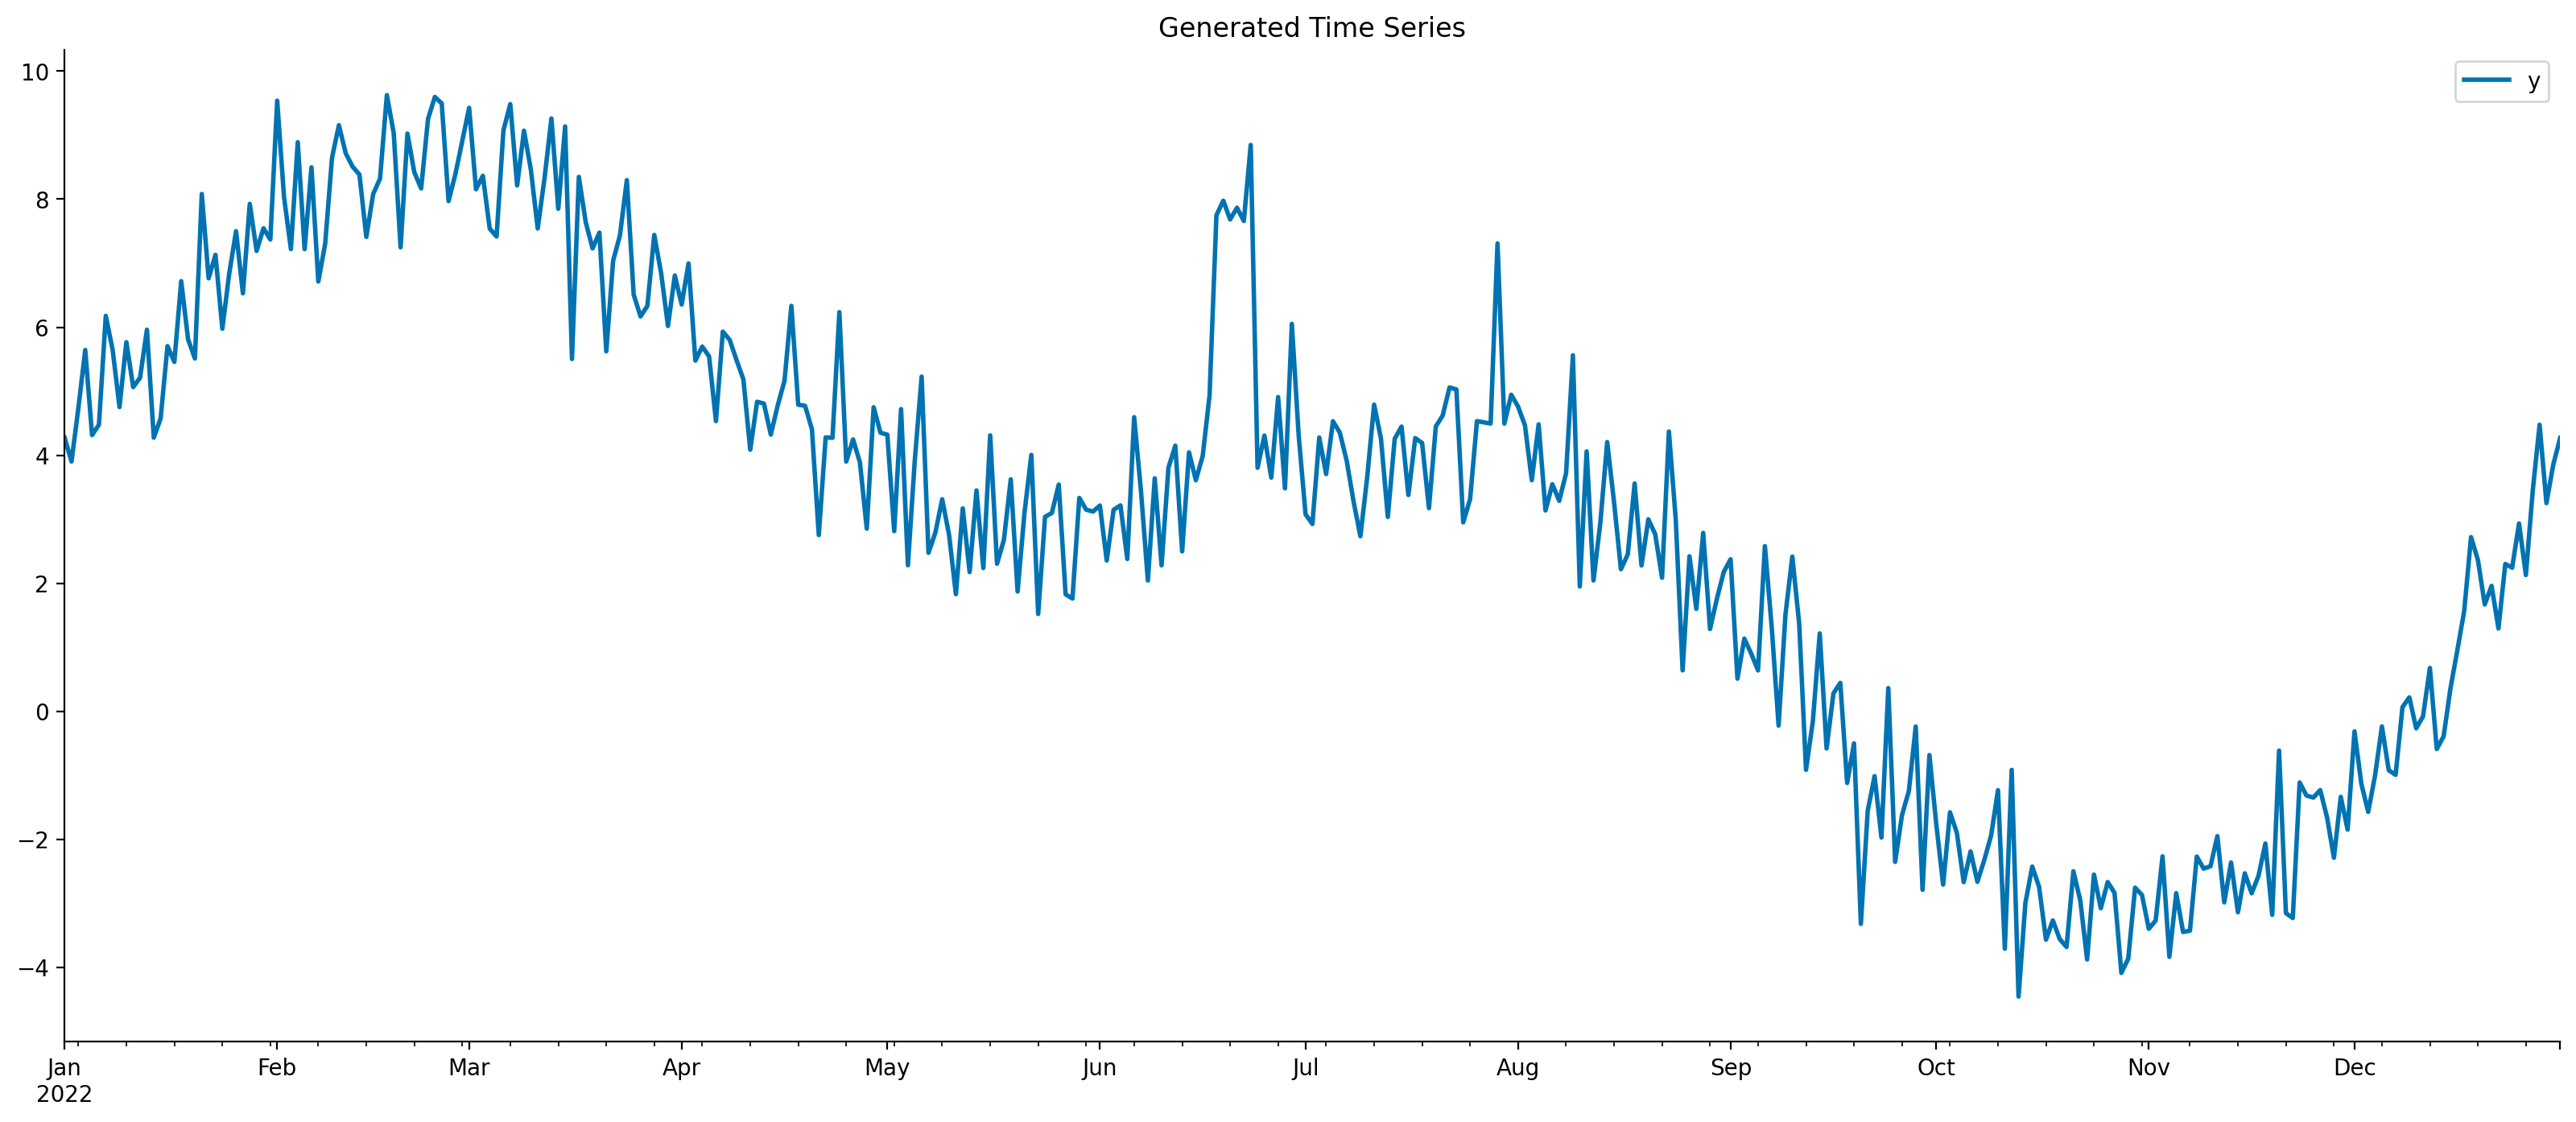

In [25]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a DataFrame with dates for the year 2022
range_of_dates = pd.date_range(start="2022-01-01", end="2022-12-31")
X = pd.DataFrame(index=range_of_dates)

# Create a sequence of day numbers and add day of the year information
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.dayofyear

# Generate components of the target time series
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))

# Combine the components to get the target series
y = signal_1 + signal_2 + noise

# Add additional random noise to specific date range (June 18 - June 23)
peak_mask = (y.index.month == 6) & (y.index.day >= 18) & (y.index.day <= 23)
y.loc[peak_mask] = y.loc[peak_mask] + np.random.normal(5, 1, len(y.loc[peak_mask]))

# Convert the target series to a DataFrame and assign a column name
y = y.to_frame()
y.columns = ["y"]

# Plot the generated time series
y.plot(title="Generated Time Series");

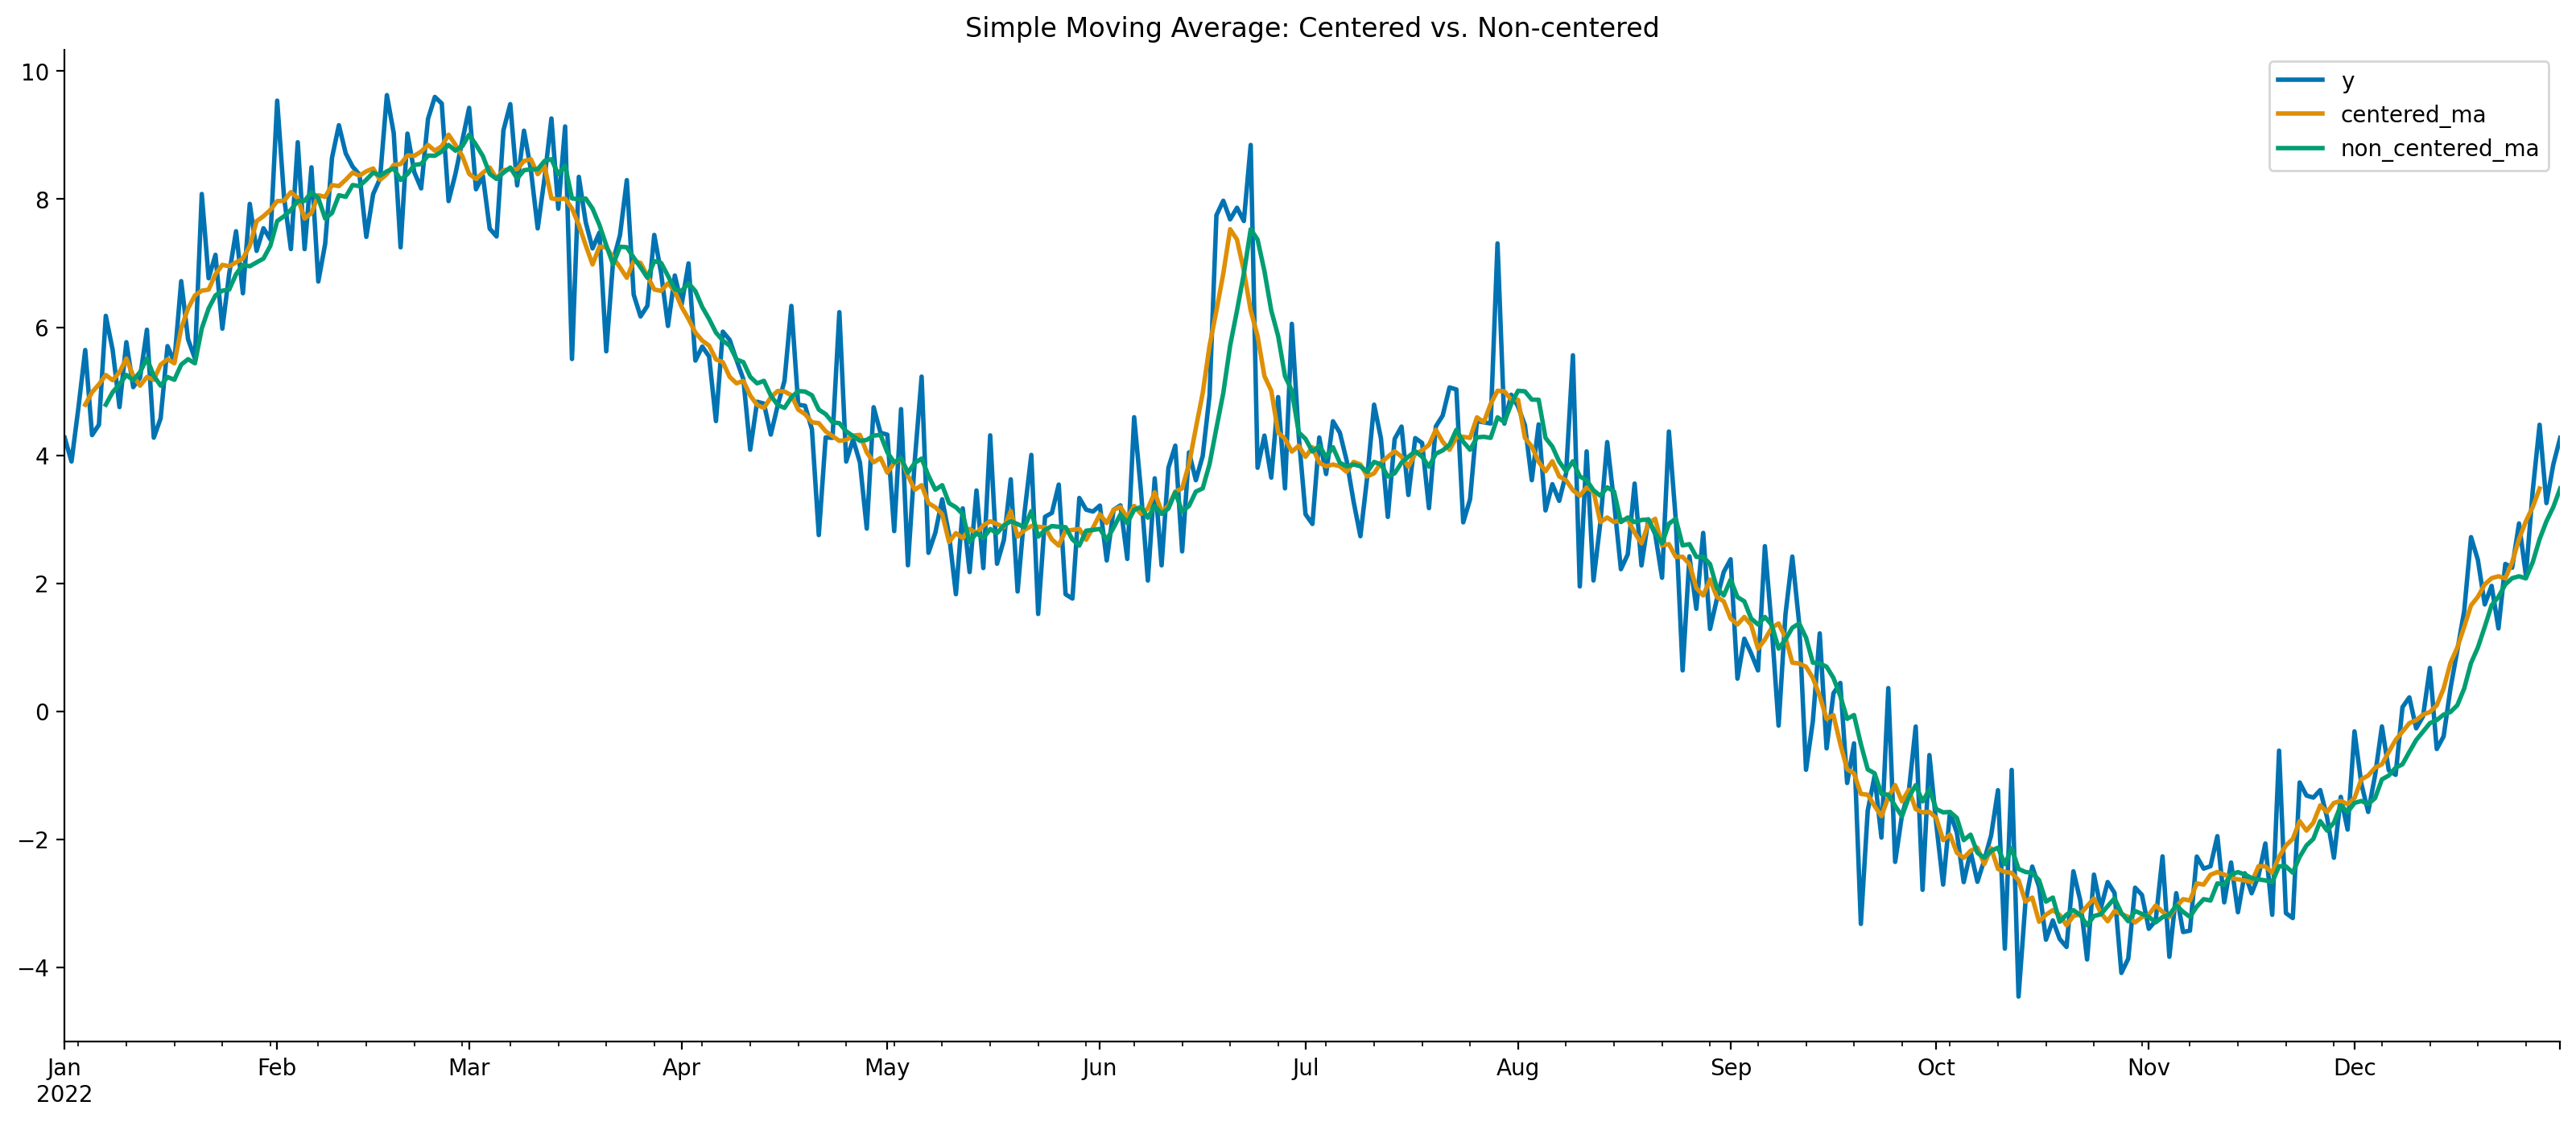

In [26]:
ma_df = y.copy()
WINDOW_SIZE = 7

ma_df["centered_ma"] = ma_df["y"].rolling(window=WINDOW_SIZE, center=True).mean()
ma_df["non_centered_ma"] = ma_df["y"].rolling(window=WINDOW_SIZE, center=False).mean()

ma_df.plot(title="Simple Moving Average: Centered vs. Non-centered");

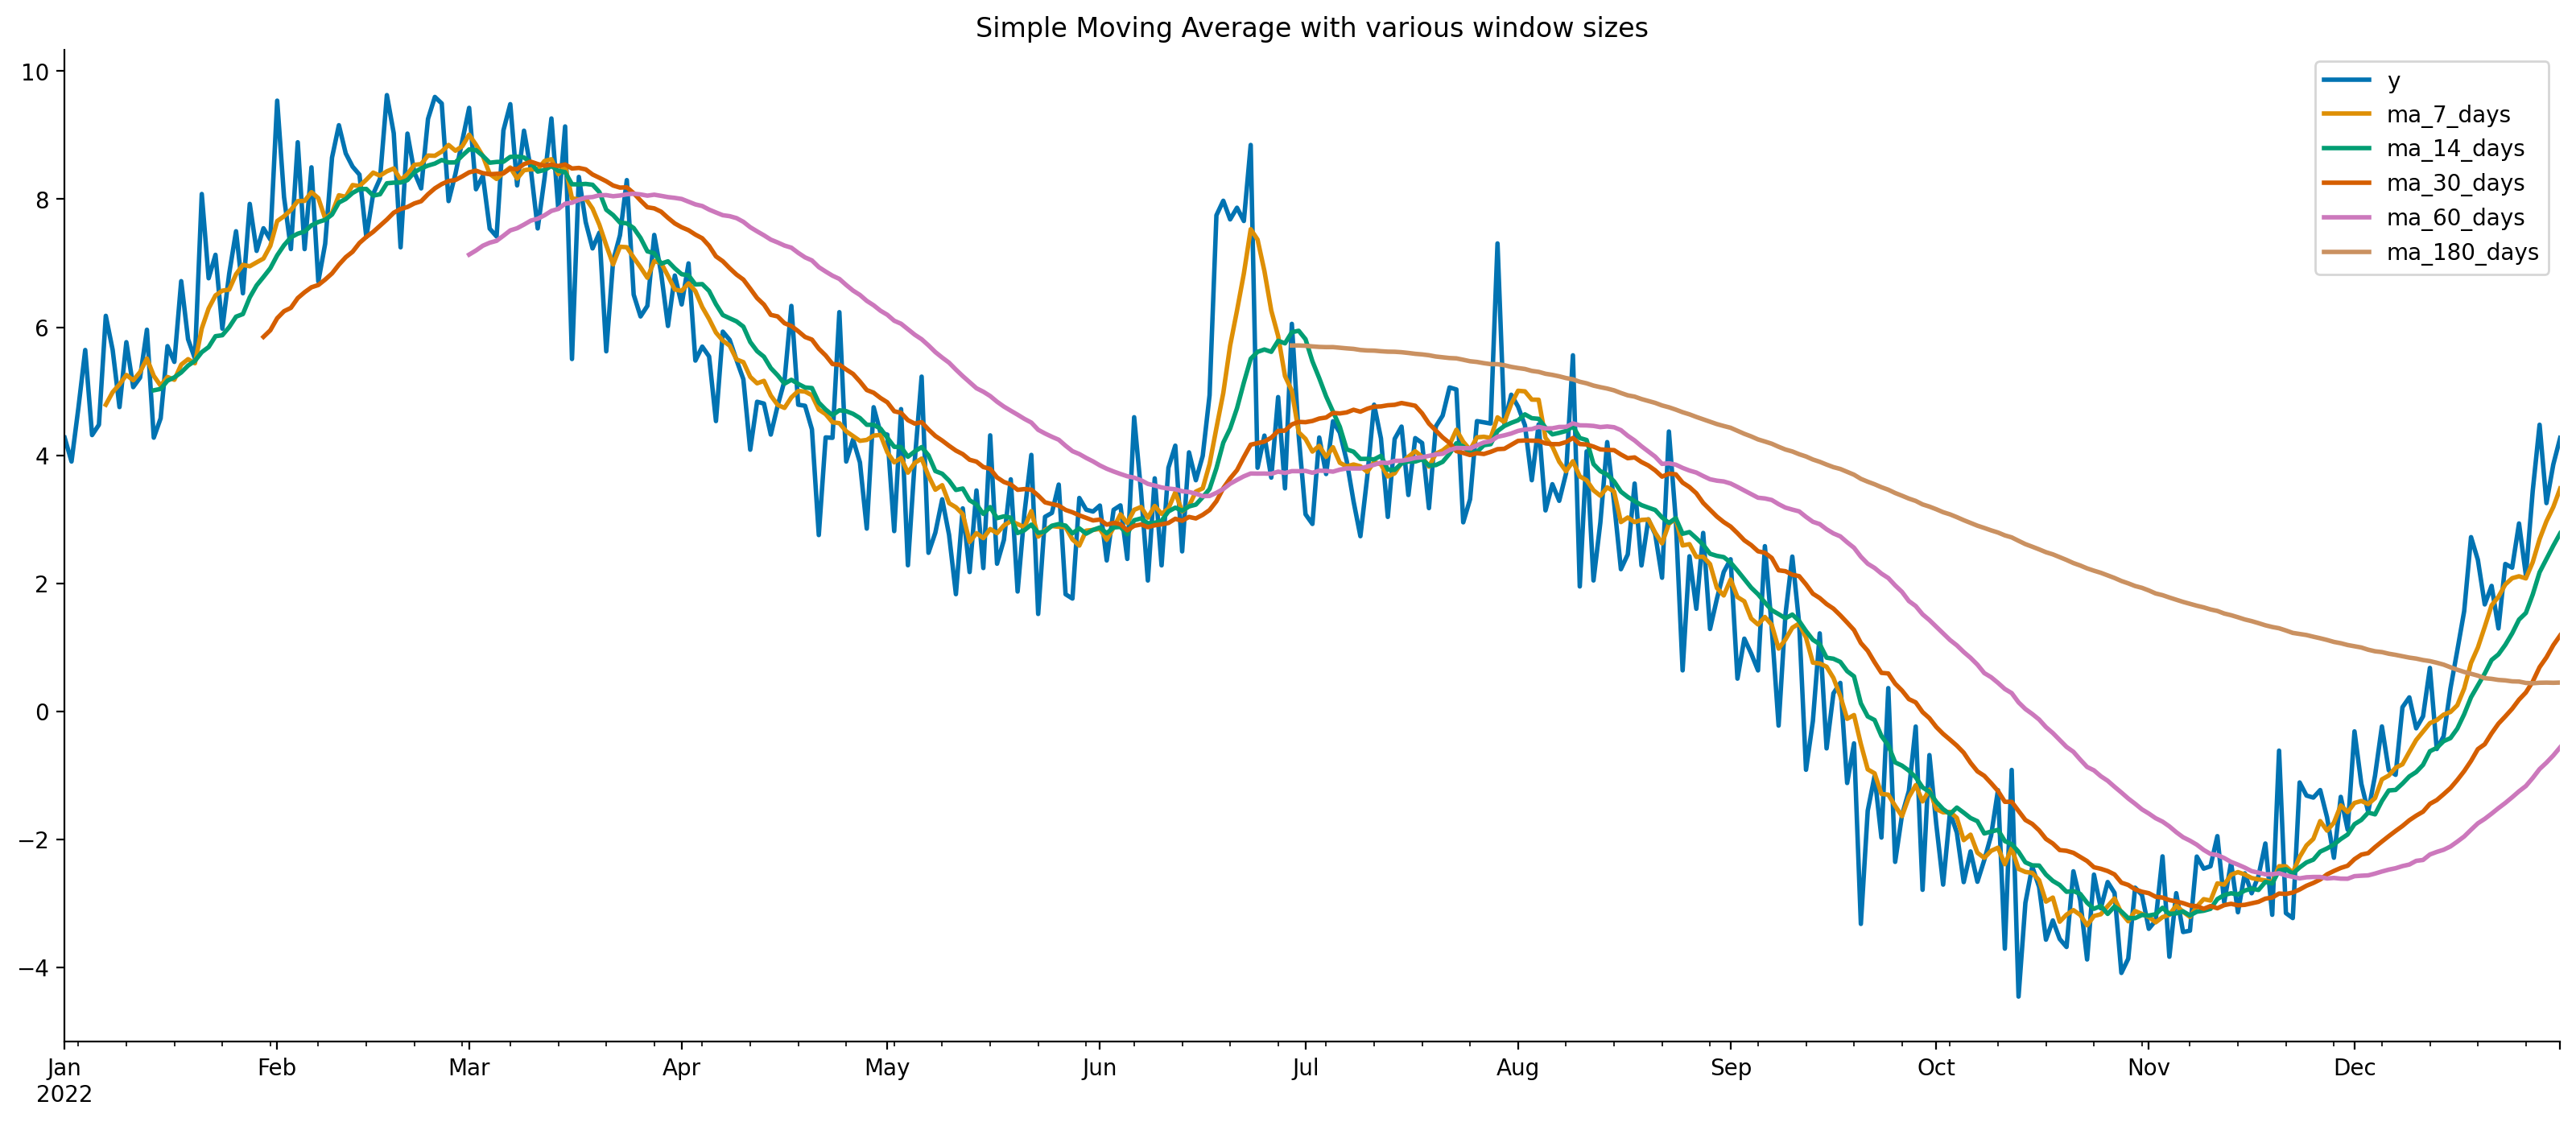

In [27]:
ma_df = y.copy()

for window in [7, 14, 30, 60, 180]:
    ma_df[f"ma_{window}_days"] = ma_df["y"].rolling(window=window).mean()

ma_df.plot(title="Simple Moving Average with various window sizes");

Exponentially Weighted Moving Average

EWMA assigns exponentially decreasing weights to data points, giving more weight to recent observations and less to older ones. This makes EWMA more responsive to recent changes in the data compared to the Simple Moving Average.
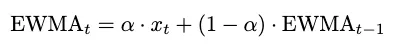
x_t is the value at time t, and α is the smoothing factor, which controls the weighting of the most recent observation in the moving average.


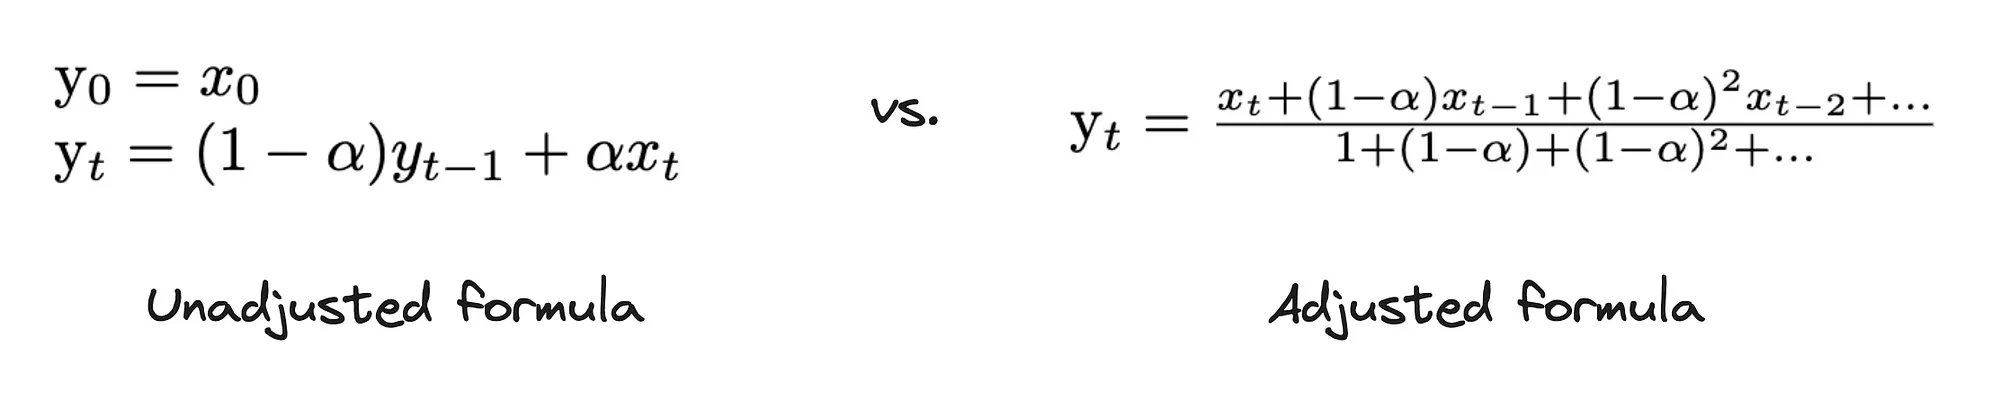

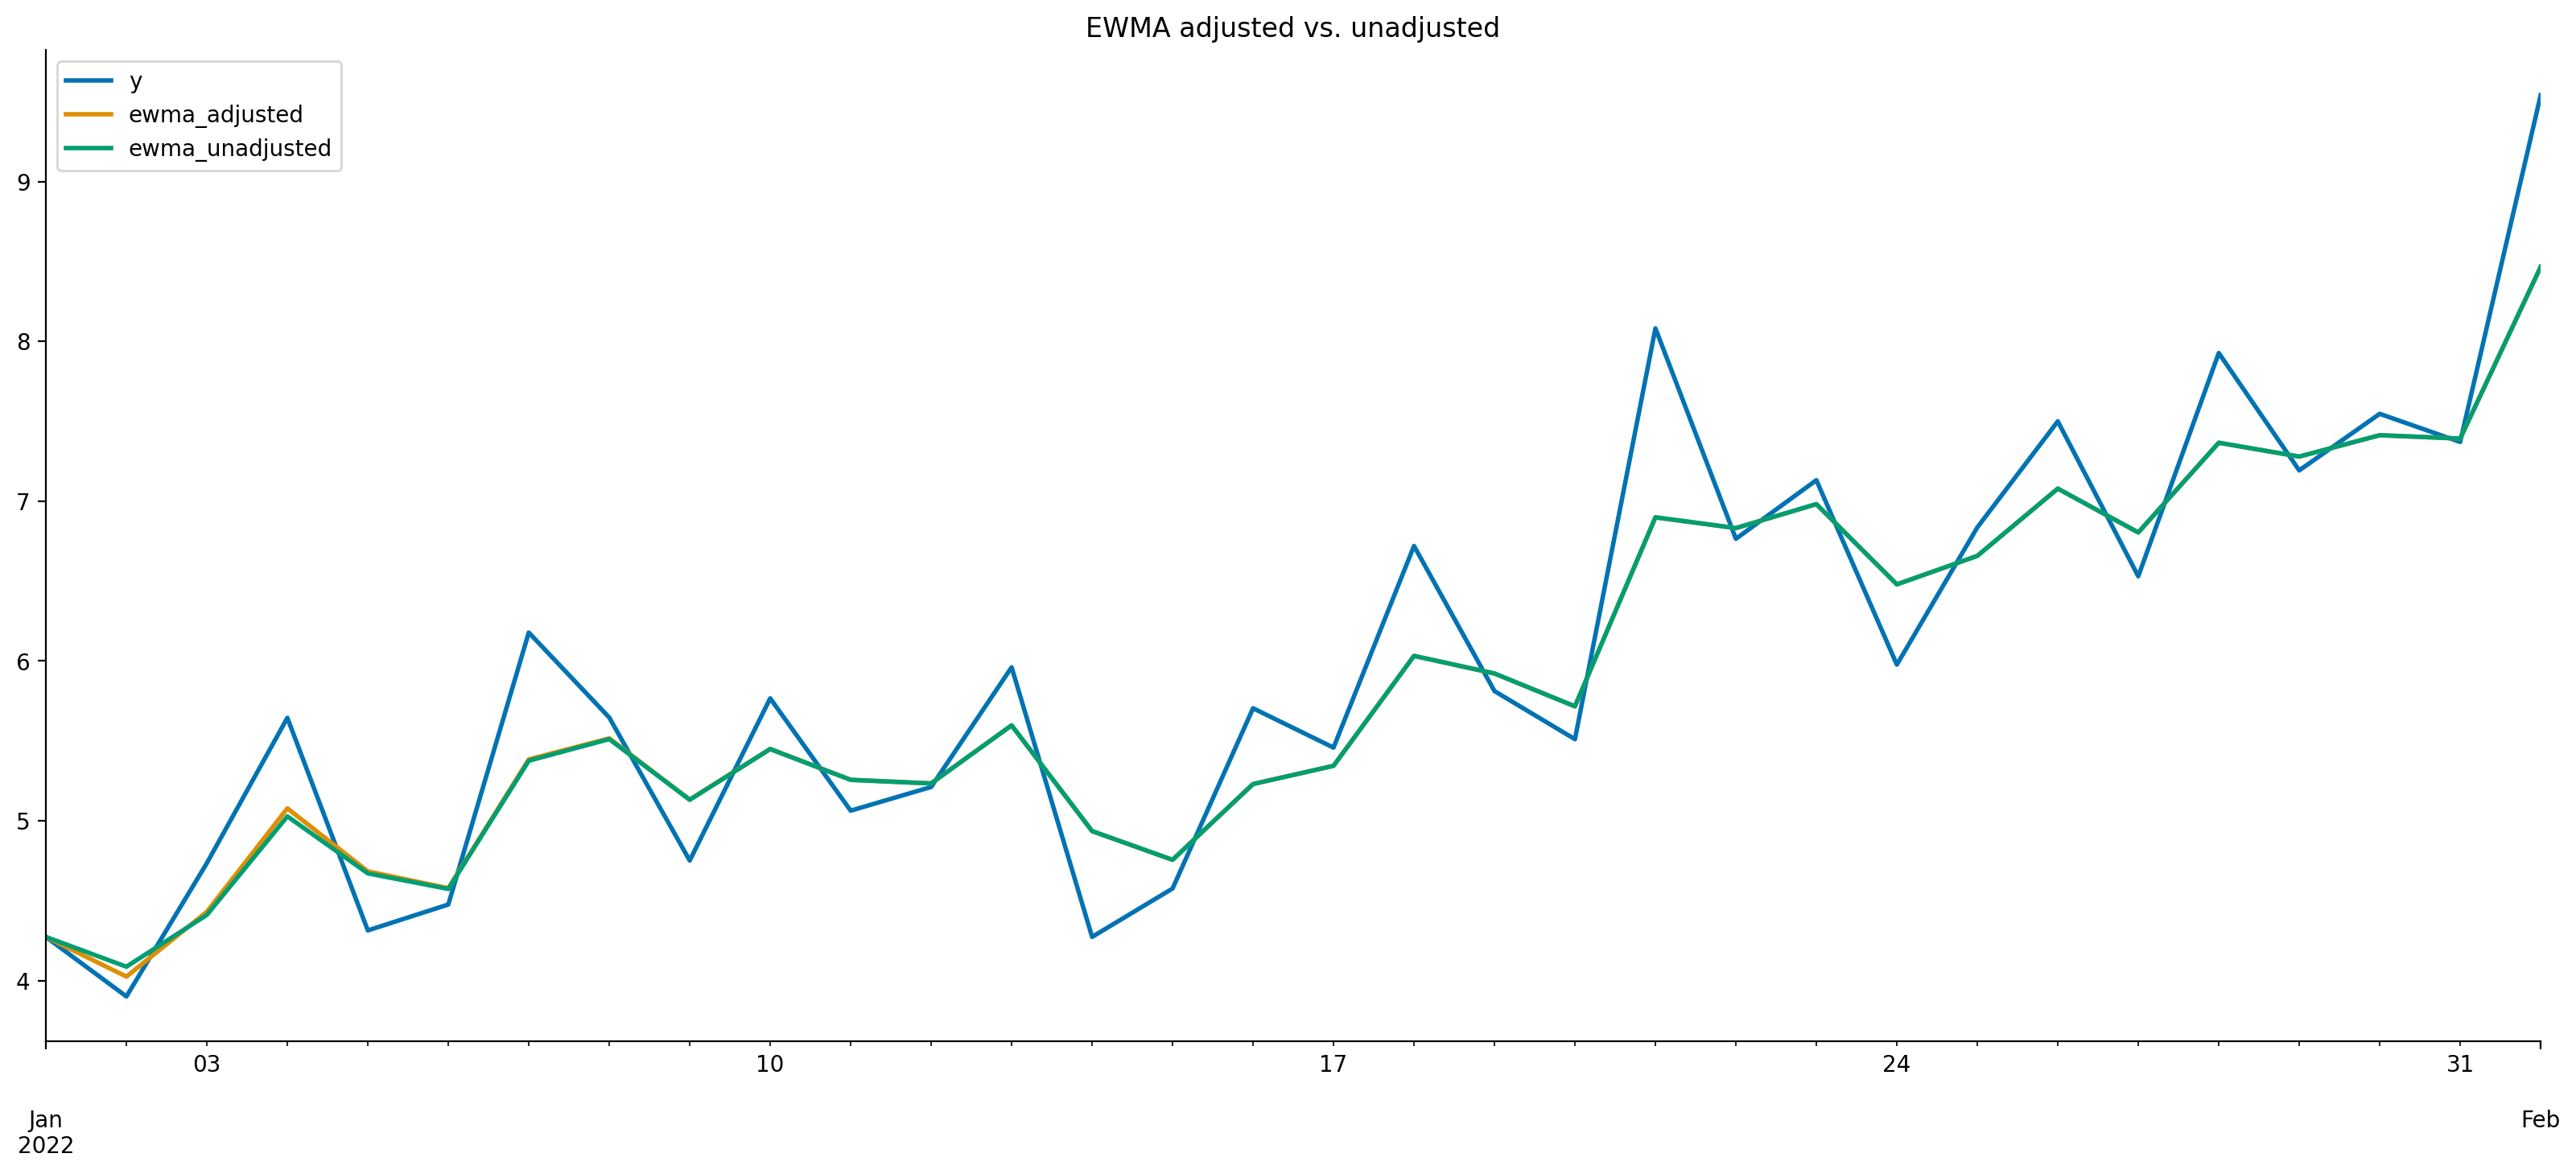

In [28]:
ewma_df = y.copy()

ewma_df["ewma_adjusted"] = ewma_df['y'].ewm(alpha=0.5, adjust=True).mean()
ewma_df["ewma_unadjusted"] = ewma_df['y'].ewm(alpha=0.5, adjust=False).mean()


ewma_df.loc["2022-01-01":"2022-02-01"].plot(title="EWMA adjusted vs. unadjusted");

Show the relationship between the value of alpha and how quickly the weight decreases in calculating the moving average. To calculate the subsequent weights, we use the formula coming from the adjusted variant of EWMA.

A smaller alpha results in a slower decay of the weights. When alpha is at its extreme value of 0.99, the EWMA essentially clings to the most recent data point and neglects the older ones.

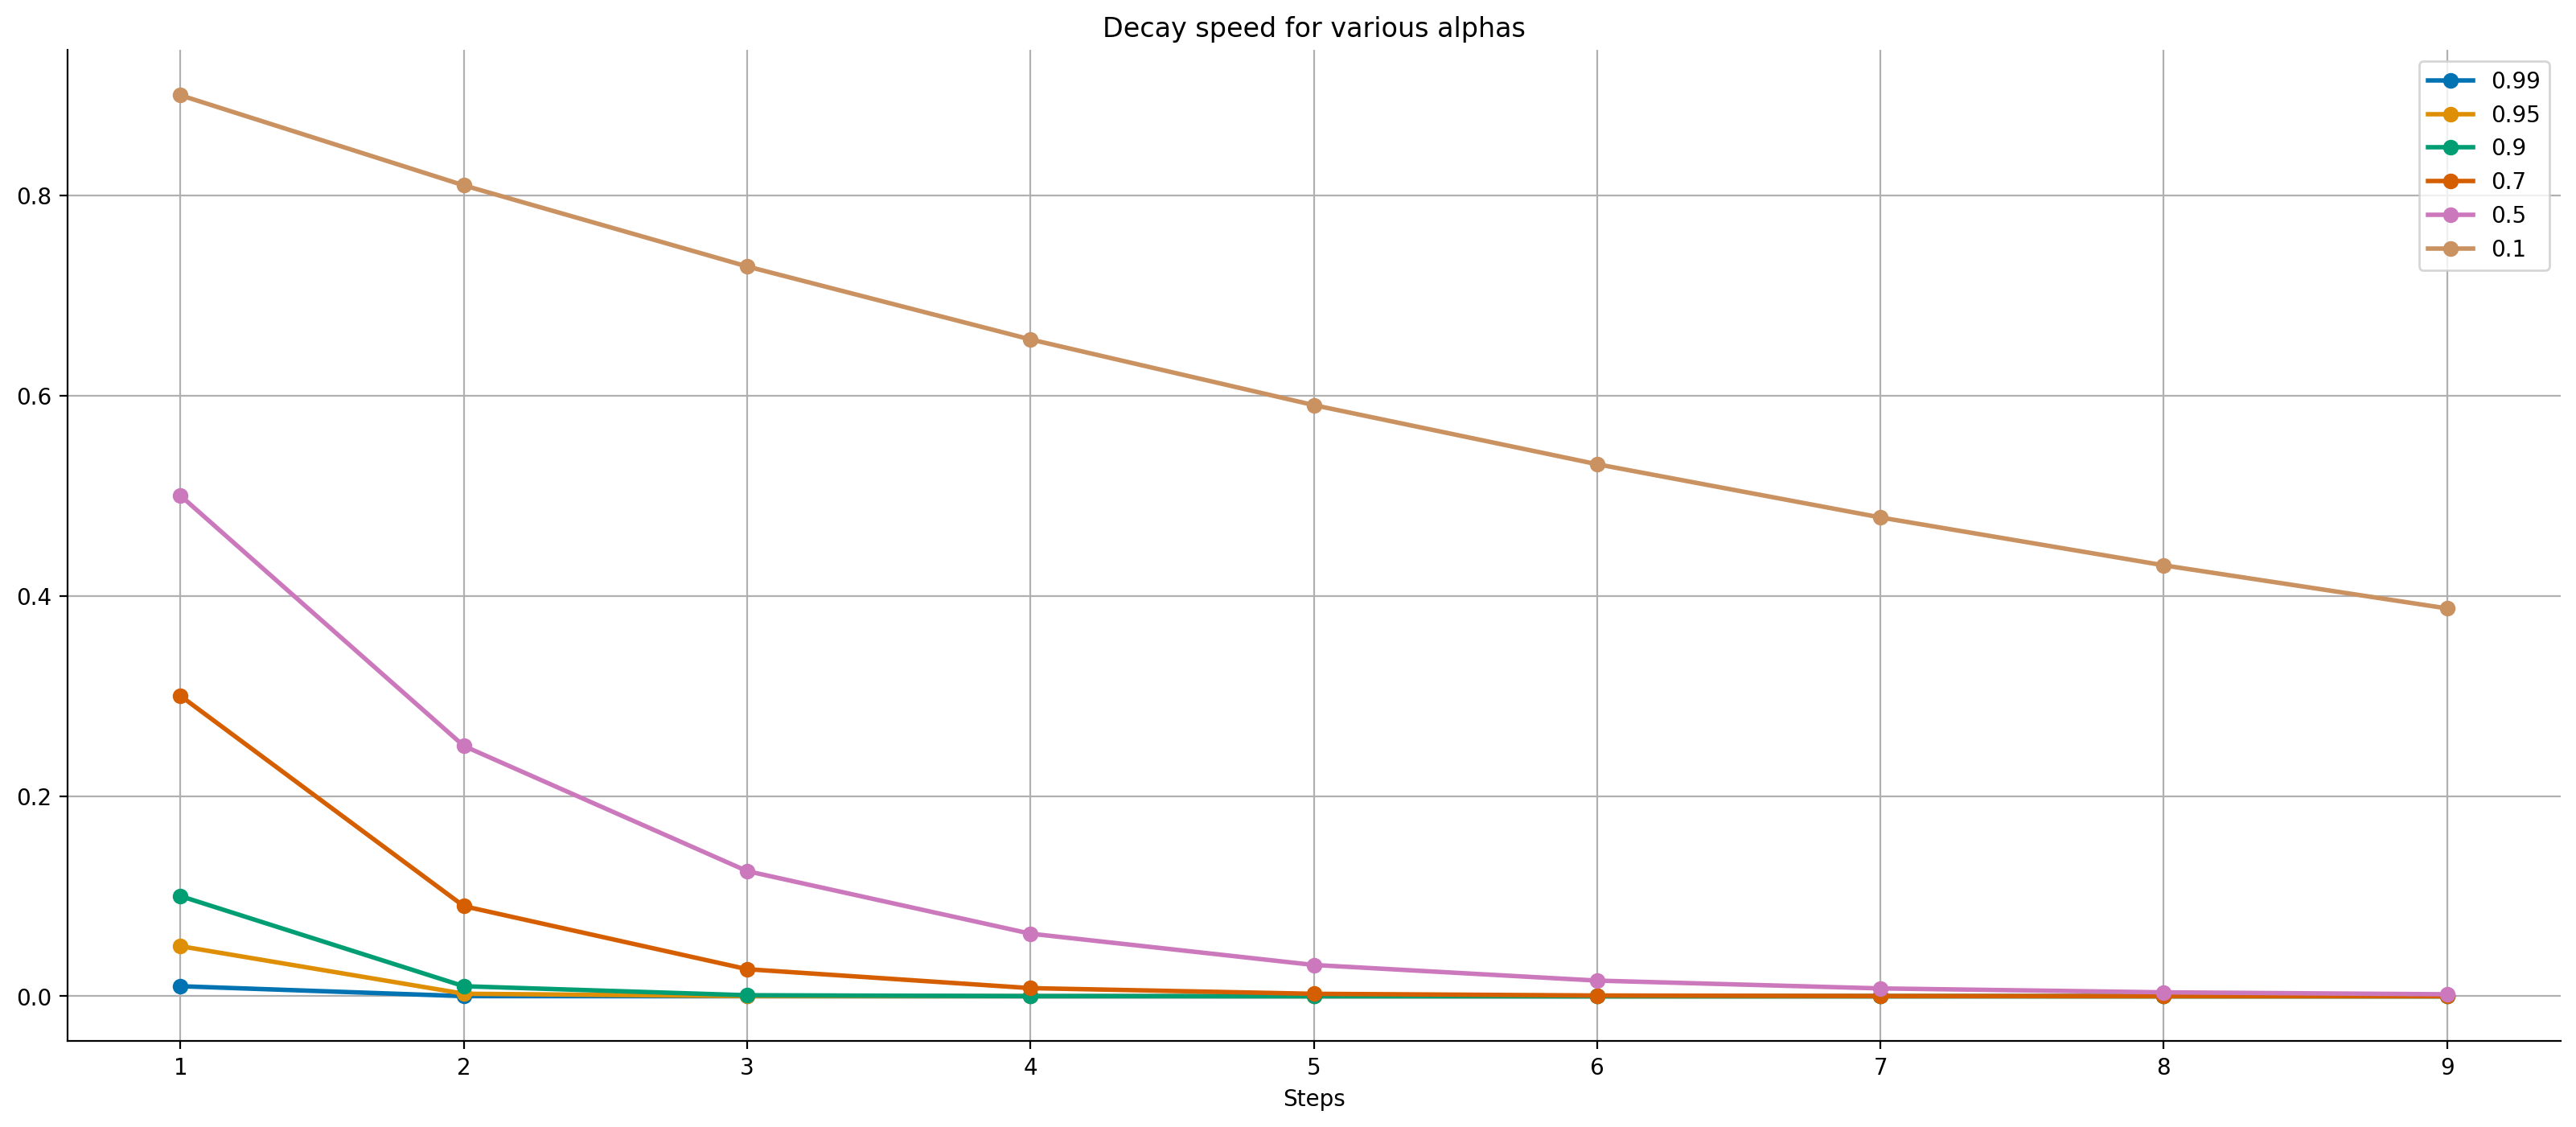

In [29]:
alpha_dict = {}
for alpha in [0.99, 0.95, 0.9, 0.7, 0.5, 0.1]:
    # this calculation assumes we are using the adjusted formula!
    alpha_dict[alpha] = [(1 - alpha) ** power for power in list(range(1, 10, 1))]

df = pd.DataFrame(alpha_dict)
df.index = range(1, len(df) + 1)

# Plot the DataFrame and set the x-label
ax = df.plot(title="Decay speed for various alphas", marker='o')
ax.set_xlabel("Steps", fontsize=10)
plt.grid(True);

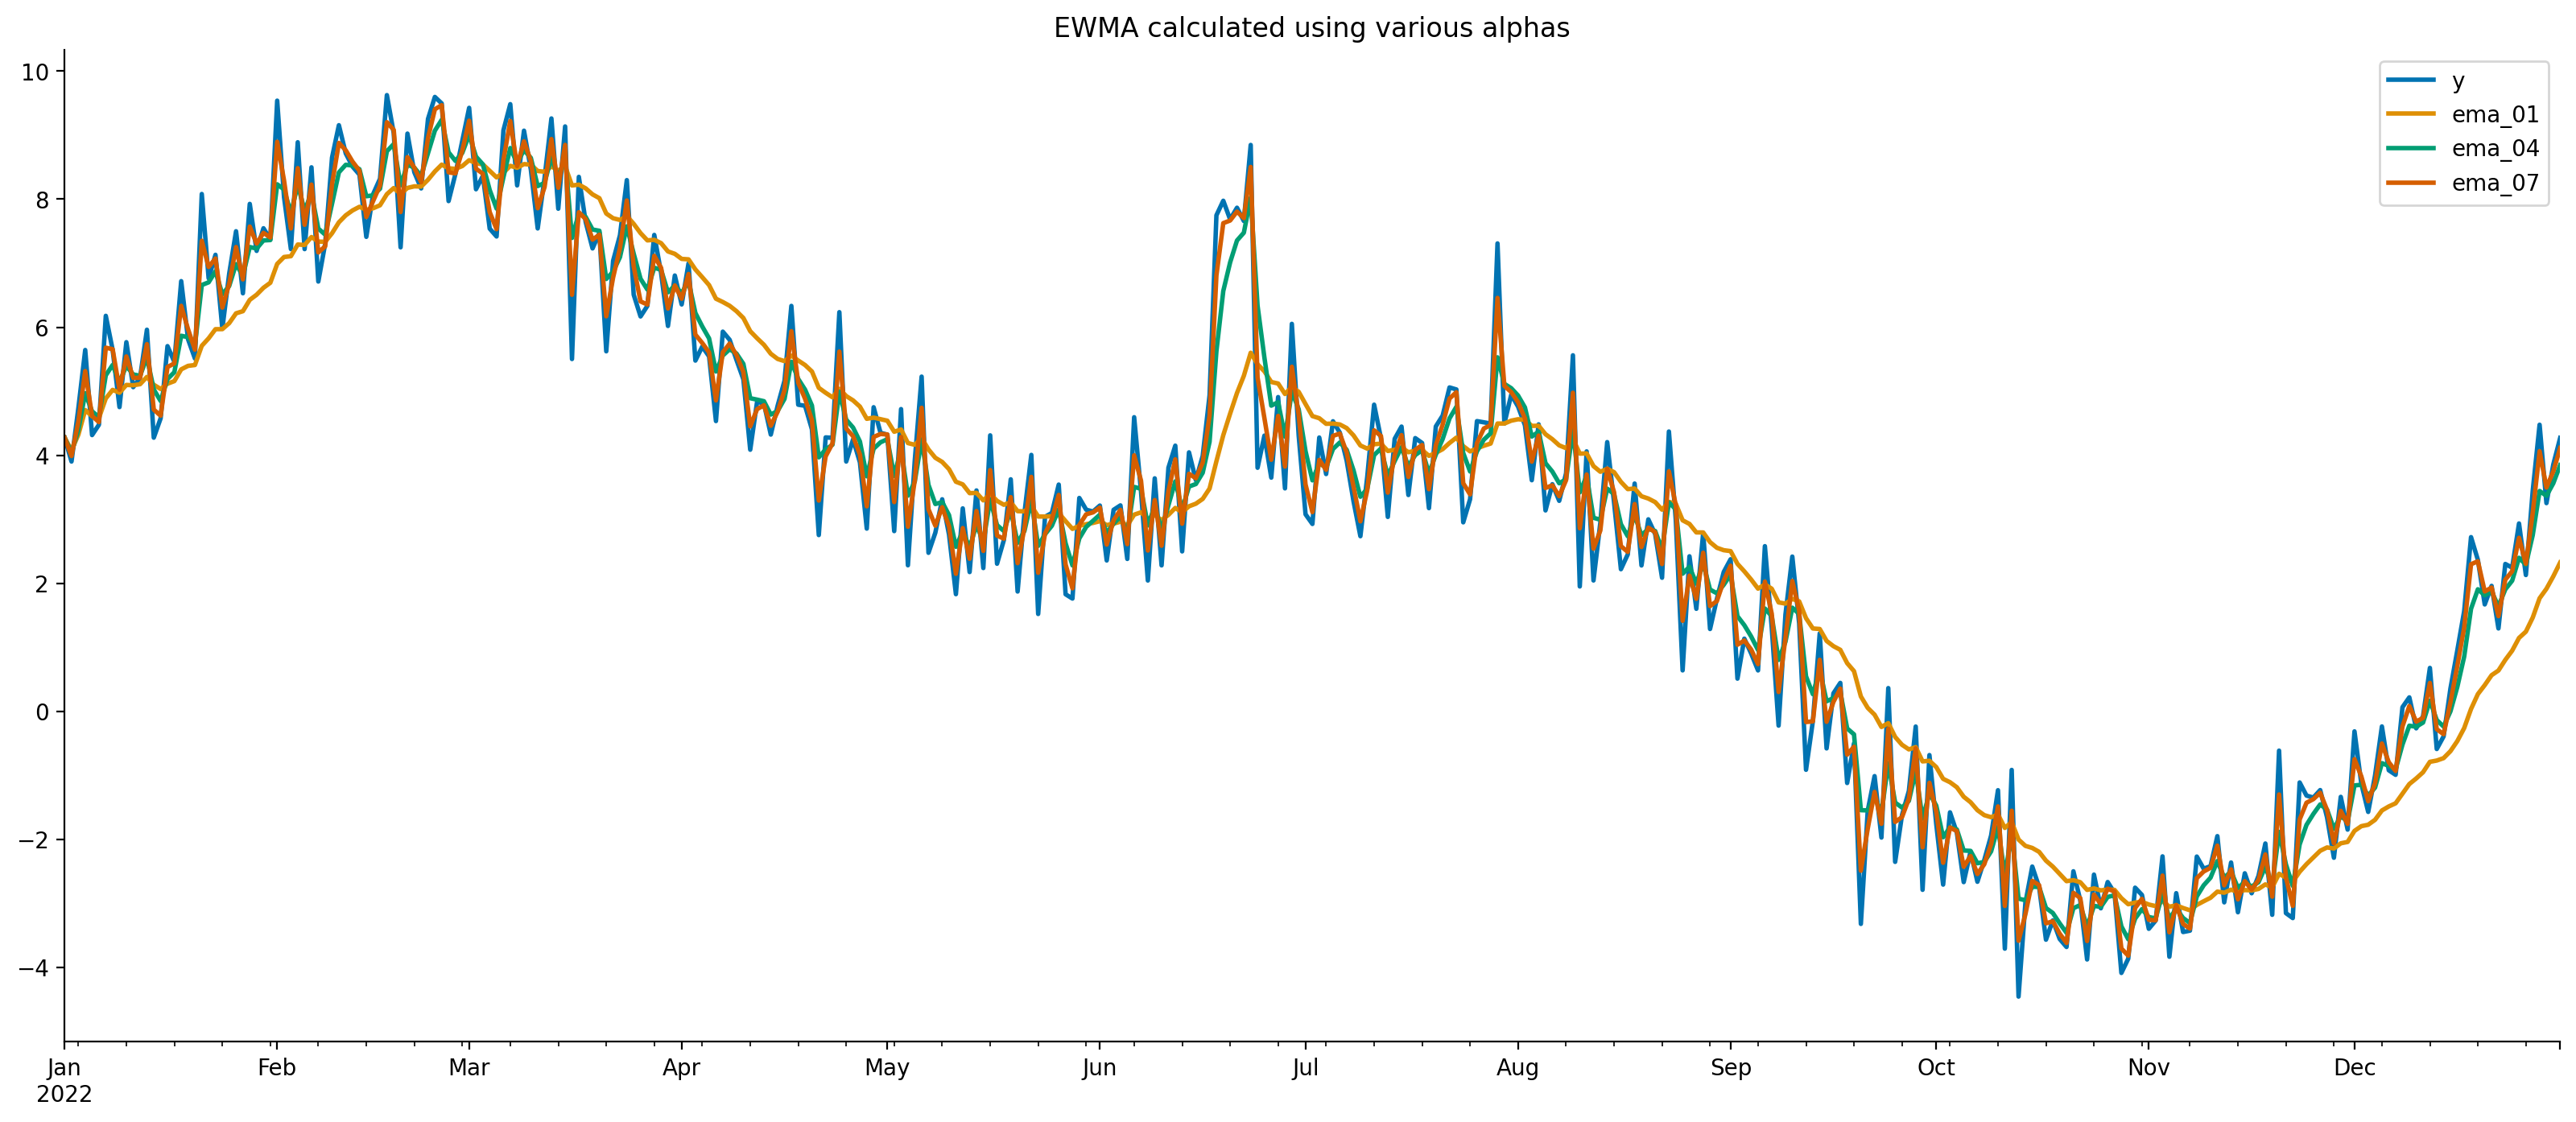

In [30]:
ewma_df = y.copy()
ALPHA_LIST = [0.1, 0.4, 0.7]

for alpha in ALPHA_LIST:
    ewma_df[f'ema_{str(alpha).replace(".", "")}'] = ewma_df['y'].ewm(alpha=alpha).mean()


ewma_df.plot(title="EWMA calculated using various alphas");

Other parameters:
- Half-life (halflife) —The half-life is essentially the time required for the decaying quantity to be reduced to half of its initial value. A smaller half-life makes recent observations more influential, thus making the EWMA more responsive to short-term changes. Conversely, a larger half-life places more weight on older data, leading to a smoother and slower-changing EWMA.
- Span (span) — The span signifies the effective window size or the number of periods considered in the EWMA calculation. In other words, it indicates how many past observations contribute to the smoothing process. A larger span includes more historical data, resulting in a smoother and slower-changing EWMA. Conversely, a smaller span focuses on recent data, making it more responsive to short-term variations.
- Center of Mass (com) — Similar to span, the center of mass parameter defines a relative position within the span. It indicates where the majority of the weighting function’s mass lies. A center of mass of 0.5 corresponds to the midpoint of the span, giving equal weight to observations on both sides. Adjusting the center of mass allows us to bias the weighting toward either recent or older data points. A smaller com shifts the center of mass closer to the present, emphasizing recent data and increasing sensitivity to short-term fluctuations. On the other hand, a larger com shifts the center of mass toward the past, resulting in a smoother and slower-changing EWMA.

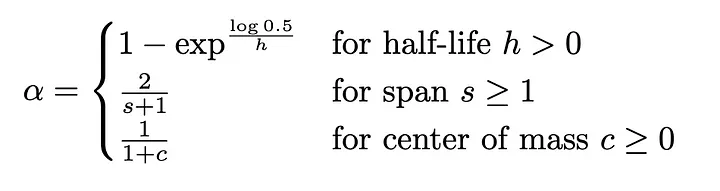

To better understand the concept, let’s consider a scenario where we are dealing with quarterly data. In our Exponentially Weighted Moving Average, we want to incorporate the data from the past year. To achieve this, we opt for a span of 4, which corresponds to an alpha value of 0.4. Below, you’ll find a table with some illustrative values.



In [20]:
param_df = pd.DataFrame(data={"value": range(0, 50)}).set_index("value")

# half-life
param_df["half_life"] = 1 - np.exp(-np.log(2) / param_df.index)
param_df.loc[0, "half_life"] = np.nan

# span (accounting for missing value for 0)
param_df["span"] = 2/(1+param_df.index)
param_df.loc[0, "span"] = np.nan

# center of mass
param_df["com"] = 1/(1+param_df.index)

print(param_df.head(15))

       half_life      span       com
value                               
0            NaN       NaN  1.000000
1       0.500000  1.000000  0.500000
2       0.292893  0.666667  0.333333
3       0.206299  0.500000  0.250000
4       0.159104  0.400000  0.200000
5       0.129449  0.333333  0.166667
6       0.109101  0.285714  0.142857
7       0.094276  0.250000  0.125000
8       0.082996  0.222222  0.111111
9       0.074125  0.200000  0.100000
10      0.066967  0.181818  0.090909
11      0.061069  0.166667  0.083333
12      0.056126  0.153846  0.076923
13      0.051922  0.142857  0.071429
14      0.048305  0.133333  0.066667


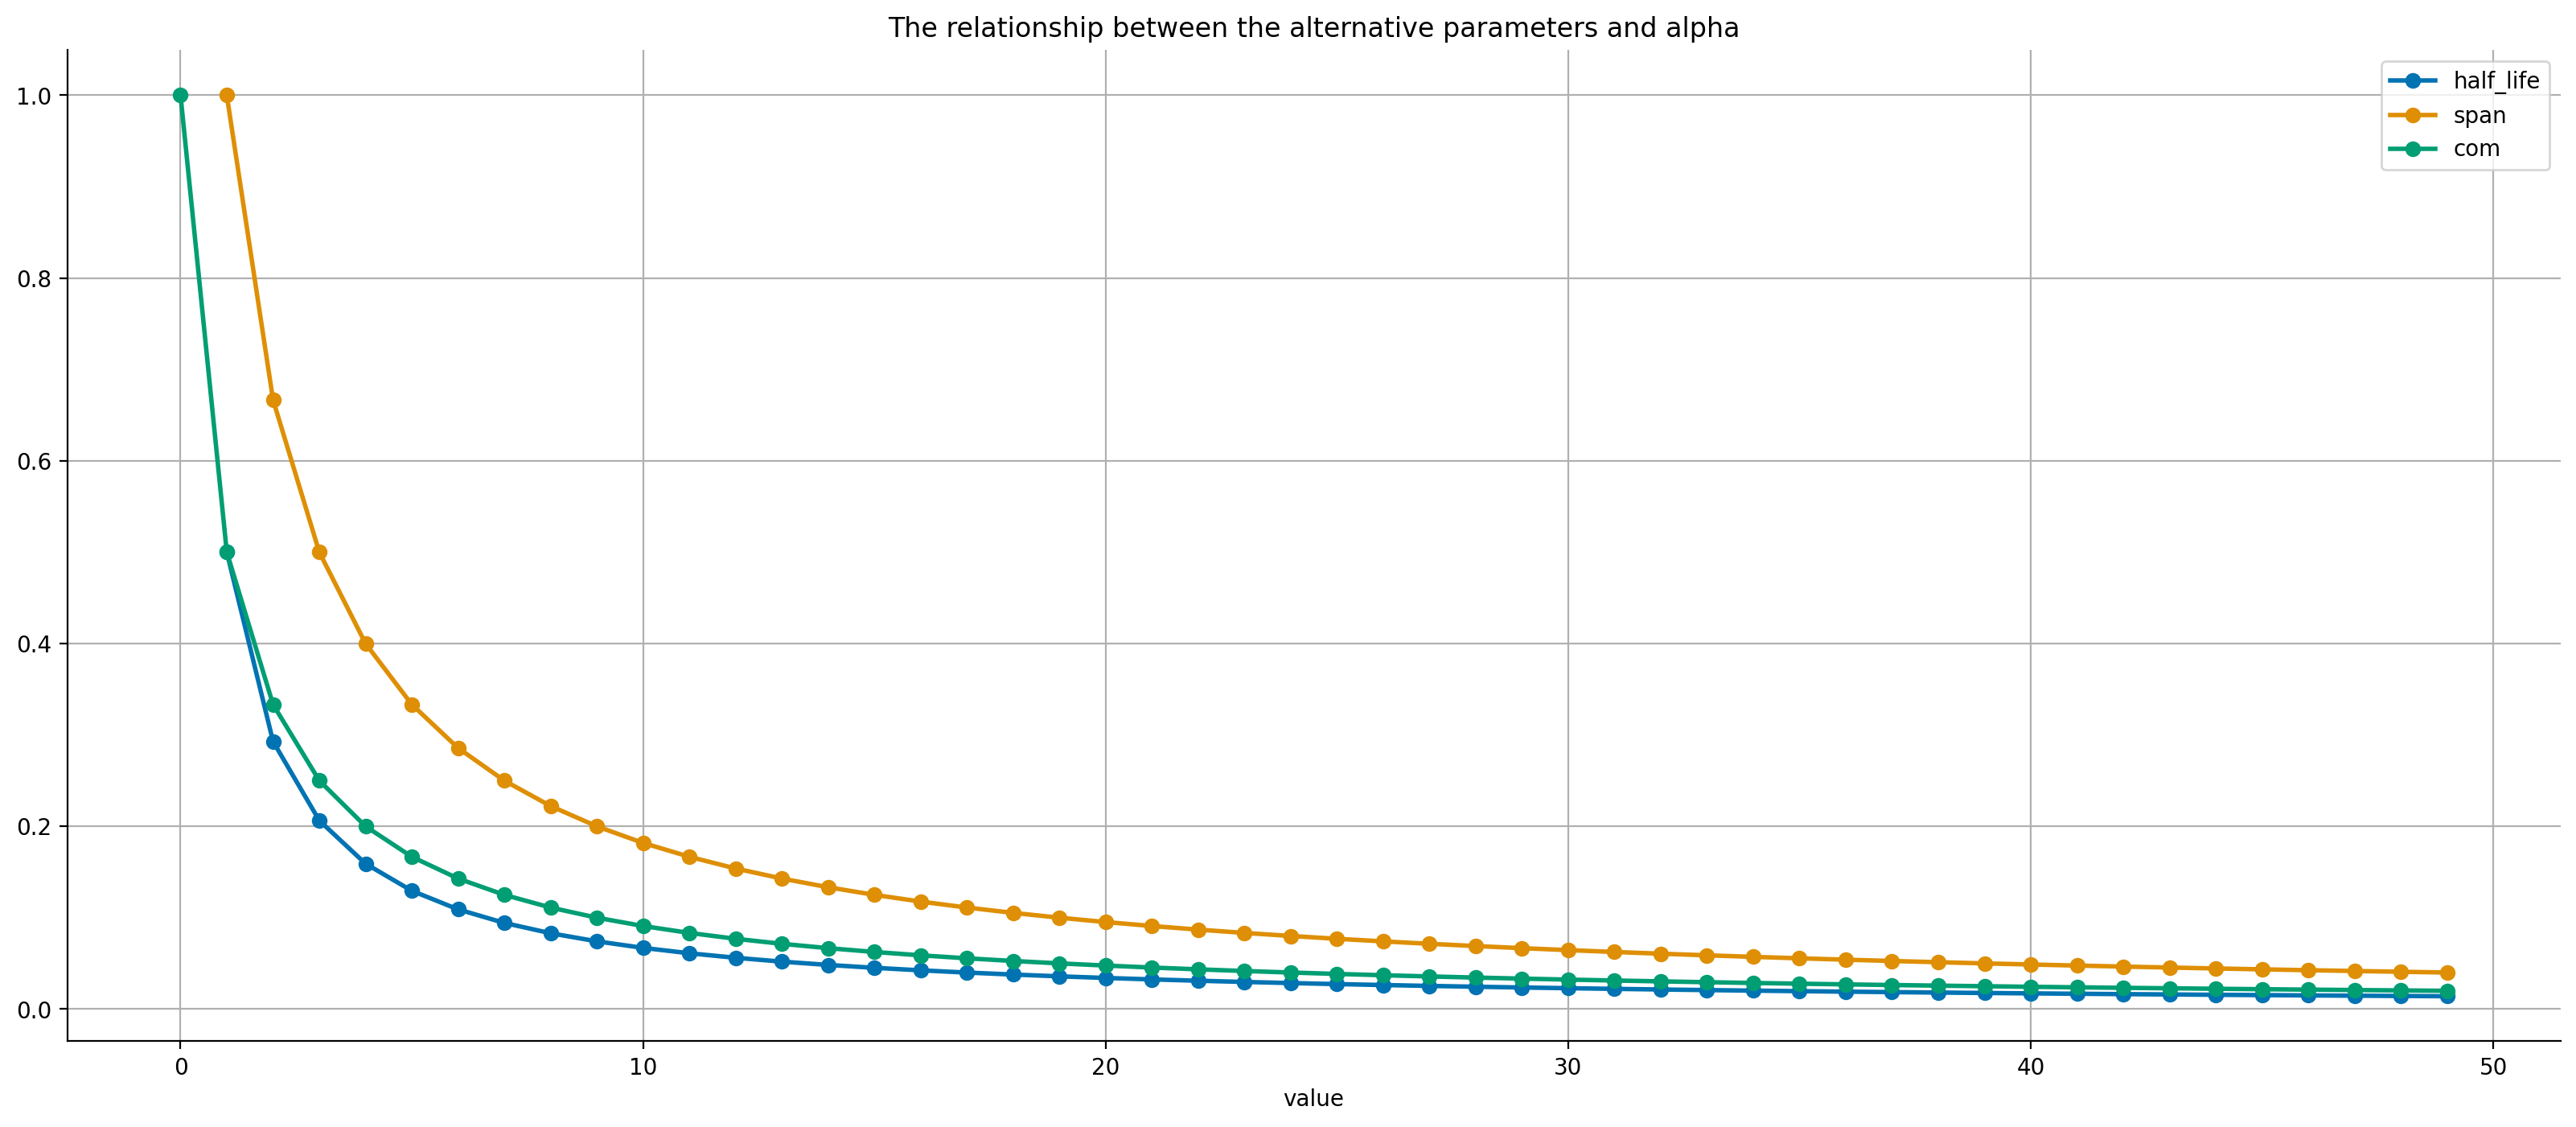

In [31]:
param_df.plot(title="The relationship between the alternative parameters and alpha", marker='o')
plt.grid(True)

The half-life parameter corresponds to the number of time periods in which a quantity will be reduced to half of its initial value. Let’s consider a half-life of 10, which corresponds to alpha = 0.066967. If we calculate the following weights using that alpha, we can clearly see that the weight for the 10th observation is equal to 0.5, as we expected.

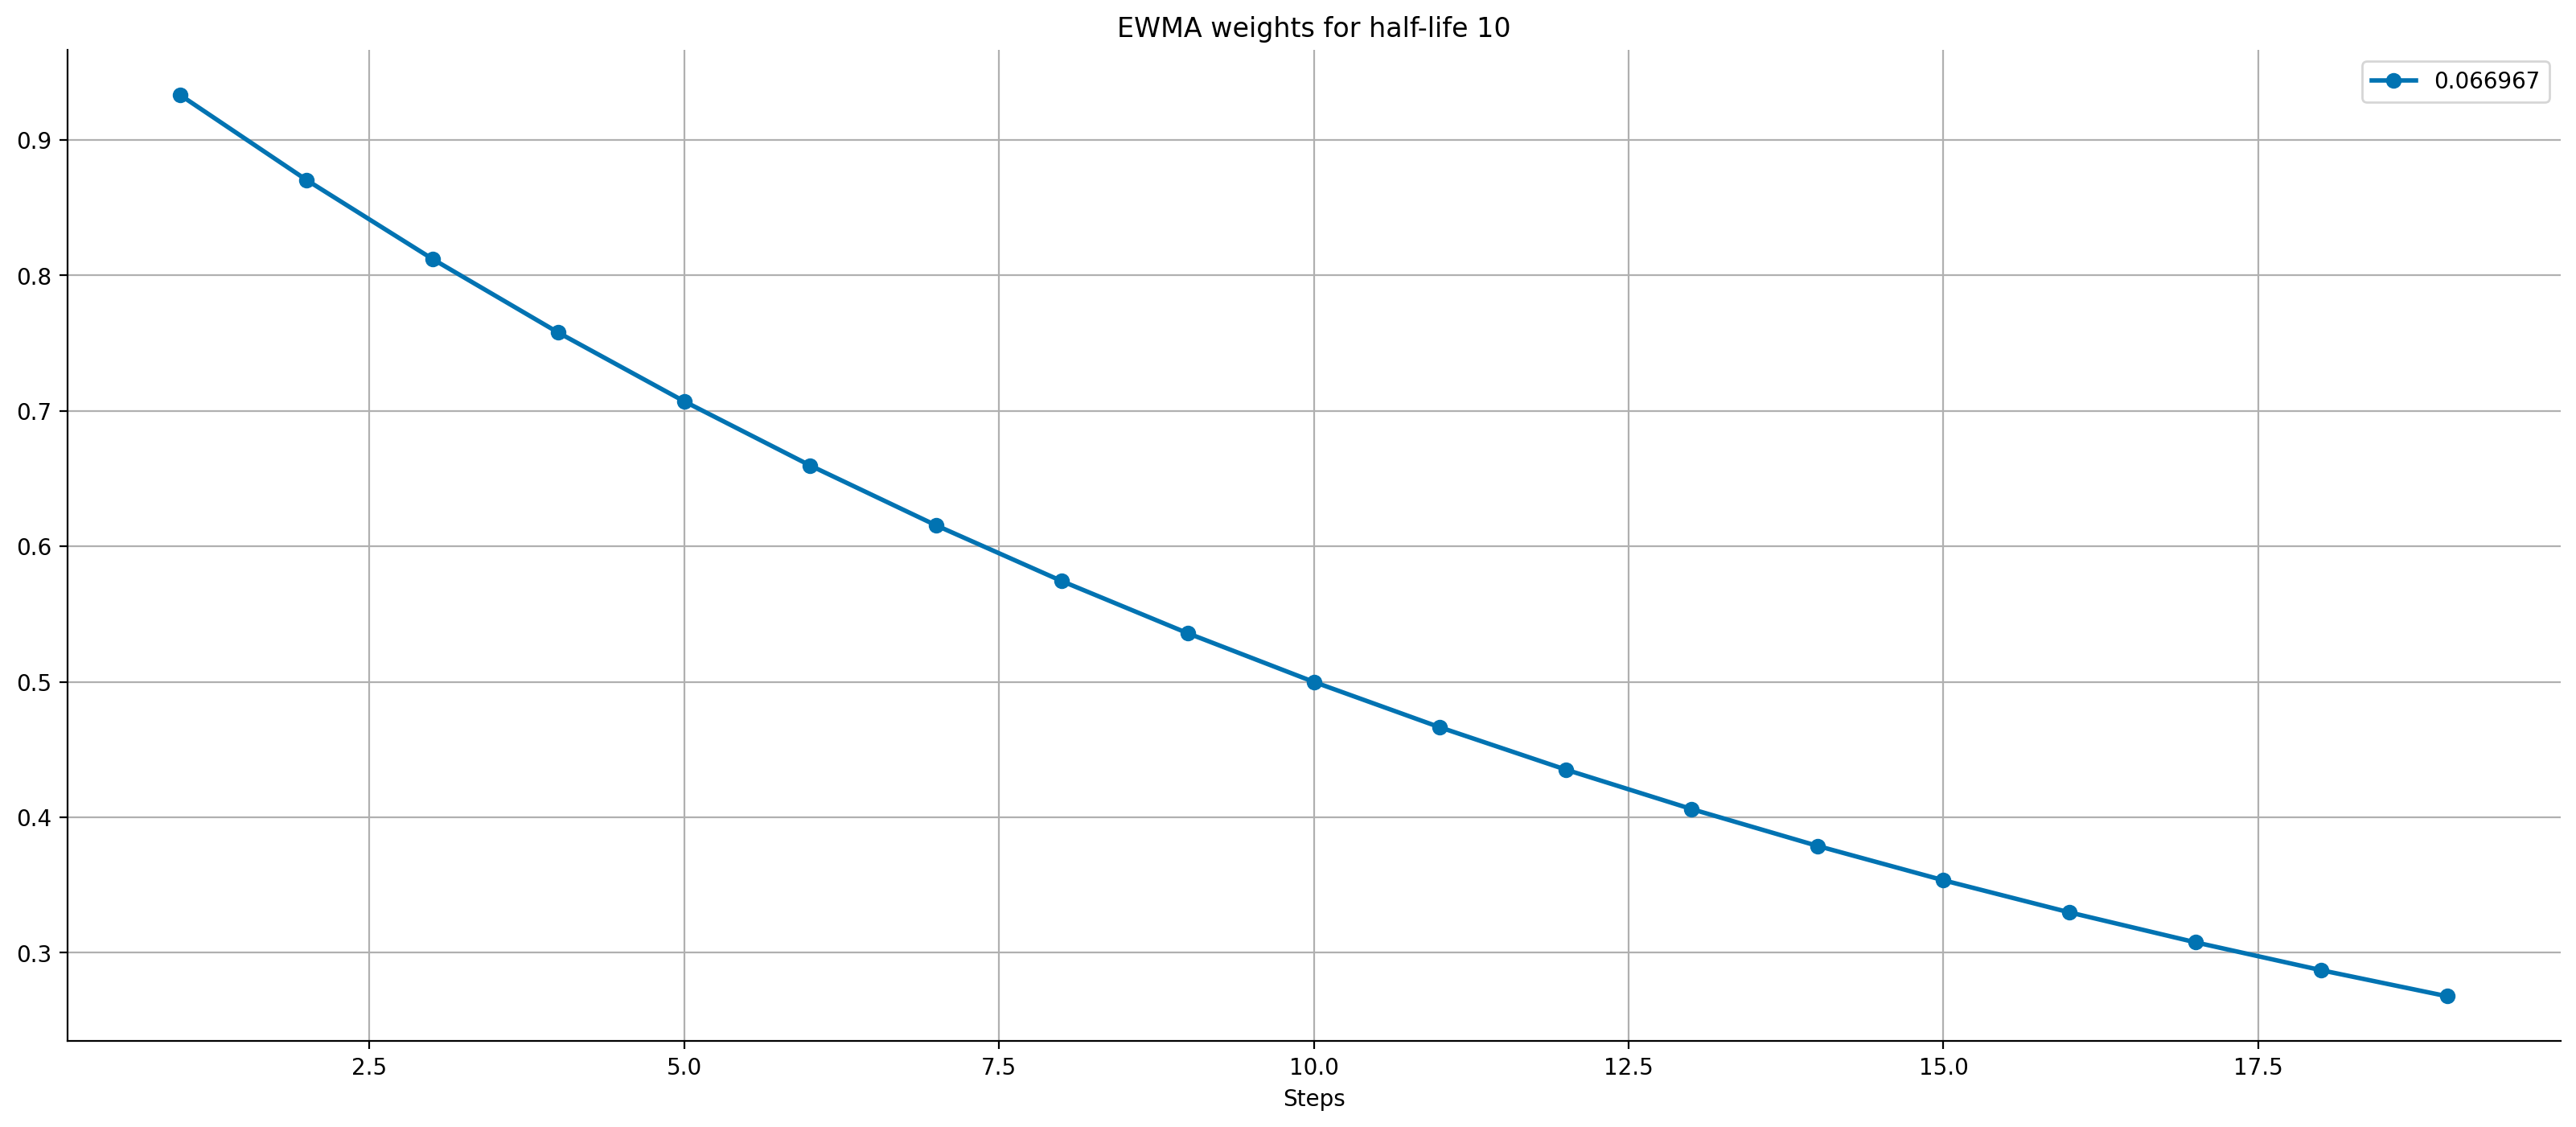

In [32]:
alpha_dict = {}

for alpha in [0.066967]:
    alpha_dict[alpha] = [(1 - alpha) ** power for power in list(range(1, 20, 1))]

df = pd.DataFrame(alpha_dict)
df.index = range(1, len(df) + 1)

# Plot the DataFrame and set the x-label
ax = df.plot(title="EWMA weights for half-life 10", marker='o')
ax.set_xlabel("Steps", fontsize=10)
plt.grid(True);